#**Handwritten digit recognition using pytorch**


**Install necessary libraries**

In [1]:
!pip install torch torchvision matplotlib

**Import necessary libraries**

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

#**load the training and test datasets**

` loaded MNIST dataset,a widely-used benchmark dataset for handwritten digit recognition tasks, with data augmentation`.




In [36]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.MNIST(
    root = 'data',
    train= True,
    transform = train_transform,
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    train= False,
    transform = test_transform,
    download = True
)

In [37]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [38]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [39]:
train_data.data.shape

torch.Size([60000, 28, 28])


`Created DataLoader objects to efficiently load and iterate over the dataset during training and testing`



In [40]:
loaders = {
    "train": DataLoader(train_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1
                        ),
    "test": DataLoader(test_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1
                        )
}

In [41]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7bc4b2f22500>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7bc4b2f20250>}

**Define CNN model architecture**

In [53]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1600, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))



        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)



**Initialize the model and define train function**

In [54]:
model = CNN()

optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(loaders["train"]):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss+= loss.item()

        if batch_idx%40==0:
          progress = 100. * batch_idx / len(loaders['train'])
          print(f'Epoch {epoch}: [{batch_idx * len(data)} / {len(loaders["train"].dataset)} ({progress:.0f}%)]\tLoss: {loss.item():.6f}')
    train_loss /= len(loaders['train'])
    return train_loss




**Now Let's define the test function**







In [55]:
def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders['test']:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders['test'].dataset)
    accuracy = correct / len(loaders['test'].dataset)
    print(f"average test loss: {test_loss:.4f}, accuracy: {accuracy:.4f}")
    return test_loss, accuracy



**Training and testing the model**

In [56]:
train_losses = []
test_losses = []
accuracies = []

for epoch in range(1, 11):
    train_loss = train(epoch)
    test_loss, accuracy = test()
    # append loss and accuracy values for plotting
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

    scheduler.step() #step the scheduler to adjust learning rate

Epoch 1: [0 / 60000 (0%)]	Loss: 2.353779
Epoch 1: [4000 / 60000 (7%)]	Loss: 1.028308
Epoch 1: [8000 / 60000 (13%)]	Loss: 0.792867
Epoch 1: [12000 / 60000 (20%)]	Loss: 0.612747
Epoch 1: [16000 / 60000 (27%)]	Loss: 0.559072
Epoch 1: [20000 / 60000 (33%)]	Loss: 0.620711
Epoch 1: [24000 / 60000 (40%)]	Loss: 0.341378
Epoch 1: [28000 / 60000 (47%)]	Loss: 0.371614
Epoch 1: [32000 / 60000 (53%)]	Loss: 0.409187
Epoch 1: [36000 / 60000 (60%)]	Loss: 0.384315
Epoch 1: [40000 / 60000 (67%)]	Loss: 0.388459
Epoch 1: [44000 / 60000 (73%)]	Loss: 0.429783
Epoch 1: [48000 / 60000 (80%)]	Loss: 0.265746
Epoch 1: [52000 / 60000 (87%)]	Loss: 0.431609
Epoch 1: [56000 / 60000 (93%)]	Loss: 0.349320
average test loss: 0.1609, accuracy: 0.9519
Epoch 2: [0 / 60000 (0%)]	Loss: 0.361569
Epoch 2: [4000 / 60000 (7%)]	Loss: 0.374152
Epoch 2: [8000 / 60000 (13%)]	Loss: 0.192351
Epoch 2: [12000 / 60000 (20%)]	Loss: 0.255405
Epoch 2: [16000 / 60000 (27%)]	Loss: 0.351334
Epoch 2: [20000 / 60000 (33%)]	Loss: 0.336216
Epoch 

**Printing loss and accuracy**

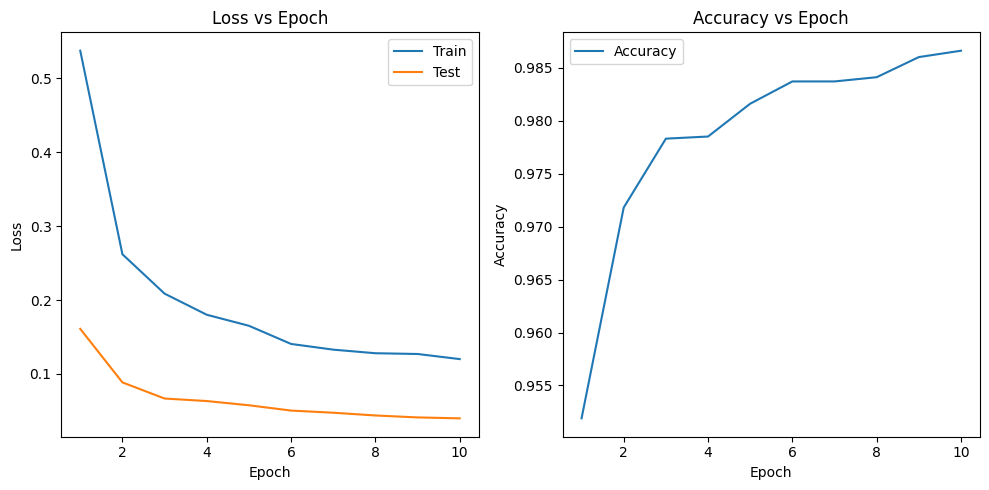

In [57]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), train_losses, label='Train')
plt.plot(range(1, 11), test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 11), accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.tight_layout()
plt.show()

**Visualization for prediction and corresponding input image**

Prediction: 1


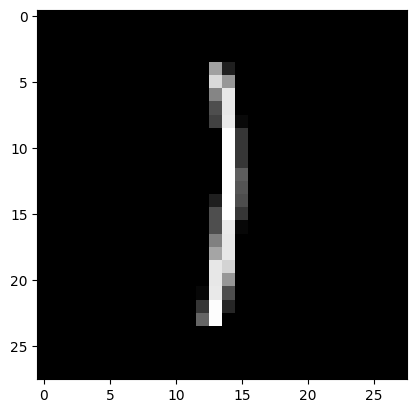

In [59]:
model.eval()
data, target = test_data[40]

data = data.unsqueeze(0)

output = model(data)

prediction = output.argmax(dim=1, keepdim=True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).numpy()

plt.imshow(image, cmap="gray")
plt.show()


**Testing the model on self captured image**

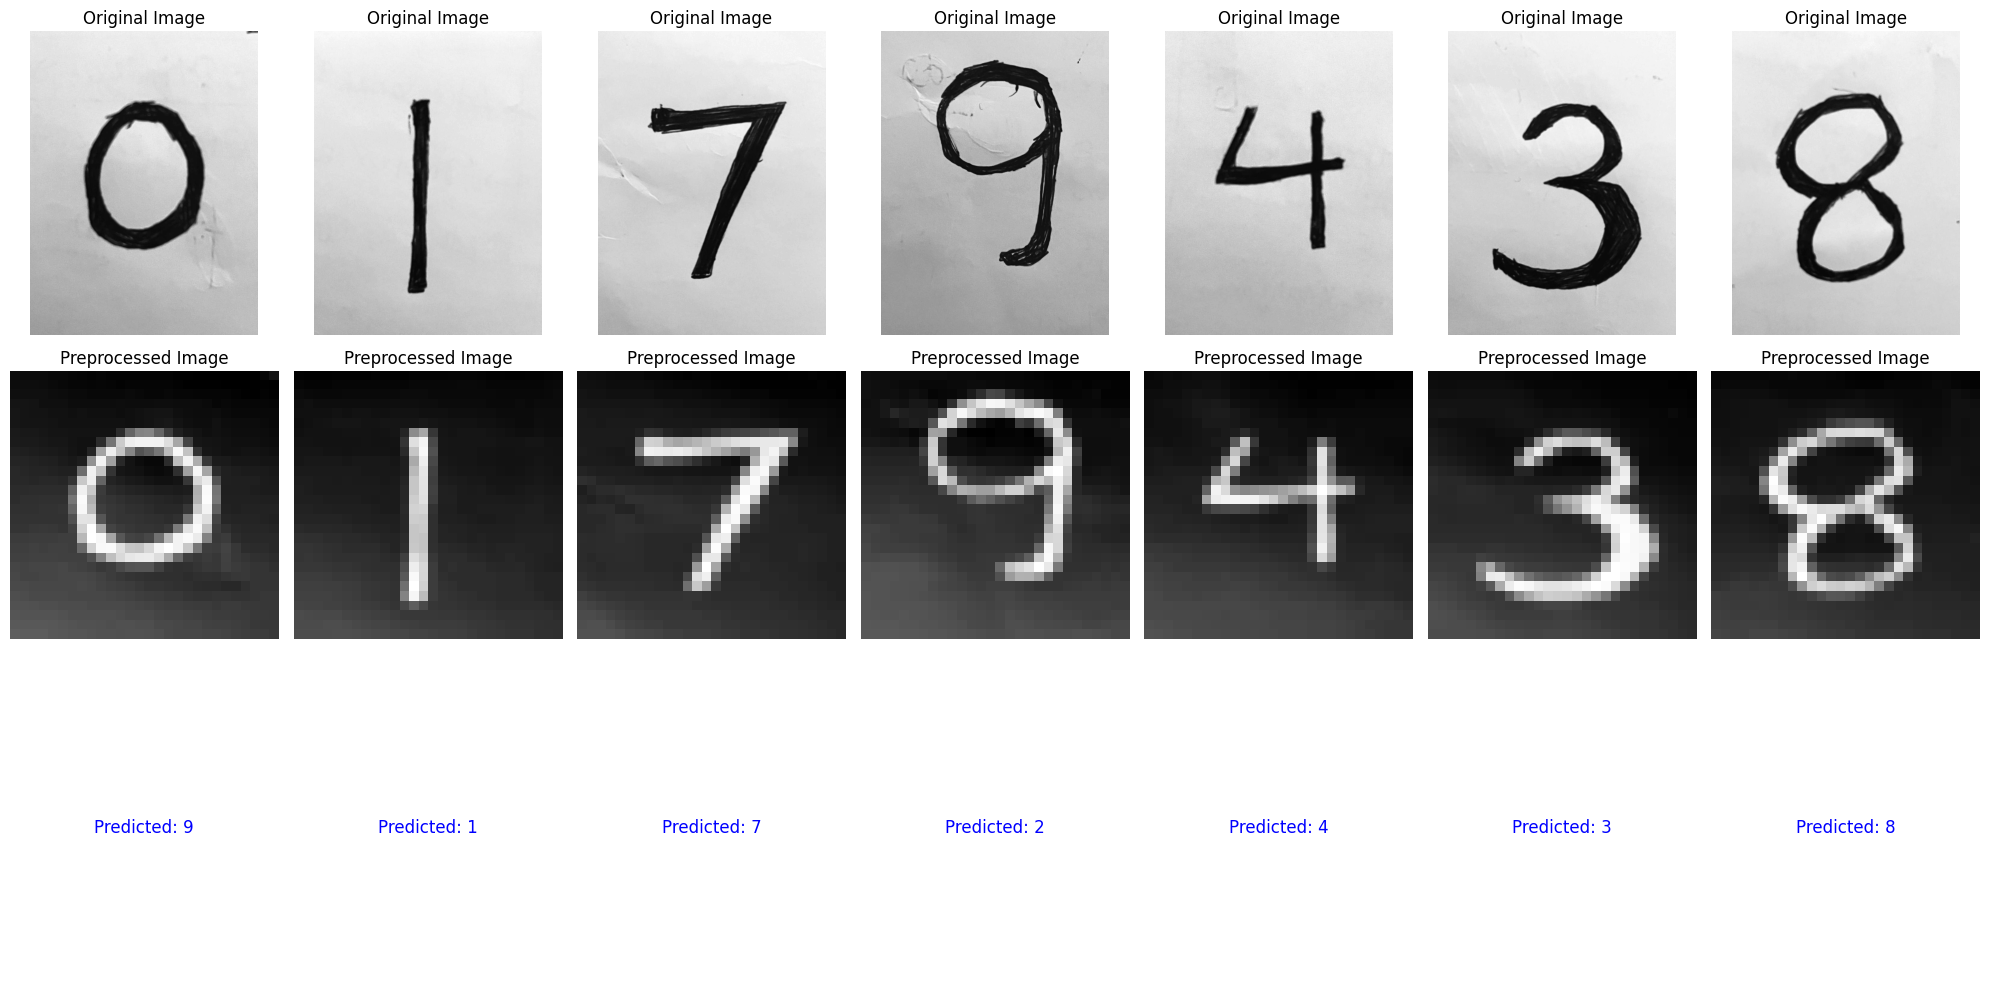

In [69]:
from PIL import Image

# Preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('L')
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Invert pixel values to have black background and white digits
    inverted_image_tensor = 1 - image_tensor
    return image, inverted_image_tensor


def predict_digit(image_tensor):
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        predicted_label = output.argmax(1).item()
    return predicted_label

# Test on multiple images
image_paths = ['image1.jpg', 'image2.jpg', 'image3.jpg', 'image4.jpg',
               'image5.jpg', 'image6.jpg', 'image7.jpg']

plt.figure(figsize=(20, 10))
for i, image_path in enumerate(image_paths, 1):
    # Preprocess the image and get the preprocessed image tensor
    original_image, preprocessed_image = preprocess_image(image_path)

    # Predict digit label
    predicted_digit = predict_digit(preprocessed_image)

    # Plot original image, preprocessed image, and prediction
    plt.subplot(3, 7, i)
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(3, 7, i + 7)
    plt.imshow(preprocessed_image.squeeze(0).permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.title('Preprocessed Image')

    plt.subplot(3, 7, i + 14)
    plt.text(0.5, 0.5, f'Predicted: {predicted_digit}', ha='center', va='center', fontsize=12, color='blue')
    plt.axis('off')

plt.tight_layout()
plt.show()
